# Задача 12 (бонусная). Экспериментальное исследование алгоритмов решения задач достижимости с КС ограничениями.

**Настройка среды**

In [ ]:
!git clone -b block3-hw4-exp https://github.com/grrrance/formal-lang-course.git
%cd formal-lang-course/
!sudo apt install python3-virtualenv
!virtualenv venv
!source venv/bin/activate
!pip install -r requirements.txt

In [2]:
import pathlib, sys, importlib.util

if importlib.util.find_spec("project") is None:
    sys.path.append(str(pathlib.Path.cwd().parent))

# Введение

Исследование посвящено анализу производительности различных алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными ограничениями: алгоритма Хеллингса, матричного алгоритма, тензорного алгоритма, а также в сравнении их со специализированным алгоритмом для регулярных ограничений.

# Поставленные вопросы

- Какой из трёх указанных алгоритмов обладает лучшей производительностью?
- Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

# Исследуемые алгоритмы

Следующие алгоритмы будут использоваться для решения задач достижимости с контекстно-свободными ограничениями:


1. Алгоритм Хеллингса: используем грамматику в виде обобщённой нормальной формы Хомского (ОНФХ). Для каждого нетерминала мы сохраняем выводимые пути из вершин в другие вершины. На каждом шаге мы выбираем один ранее неиспользованный путь и пытаемся объединить его с другими найденными выводимыми путями.
2. Матричный алгоритм : используем грамматику в виде ОНФХ. Храним матрицу достижимости, где элементы представляют собой множества нетерминалов, из которых выводятся пути между вершинами. На каждом шаге мы прибавляем к матрице достижимости её квадрат и продолжаем этот процесс до тех пор, пока матрица изменяется.
3. Тензорный алгоритм : используем рекурсивный автомат, который построен на основе грамматики. На каждом шаге итерации мы находим пересечение графа и автомата, используя произведение Кронекера. Затем мы добавляем ребра с метками нетерминалов в граф для тех пар вершин, для которых были найдены пути, выводимые из этих нетерминалов.

Следующий алгоритм будет использоваться для решения задач достижимости с регулярными ограничениями:

Тензорный алгоритм: с помощью произведения Кронекера мы создаем матрицу смежности для конечного автомата, который распознает пересечение языков, определенных графом и запросом. Затем мы применяем операцию нахождения транзитивного замыкания этой матрицы.

# Оборудование

In [3]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [4]:
!lscpu | grep -E 'Architecture|Model name|Thread|Core'

Architecture:                       x86_64
Model name:                         Intel(R) Xeon(R) CPU @ 2.30GHz
Thread(s) per core:                 2
Core(s) per socket:                 1


In [5]:
!nvidia-smi

Thu Dec 14 23:01:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Используемые данные


В качестве графов для экспериментов будут использоваться графы из cfpq-data датасета. Были выбраны следующие графы из различных категорий:


1.   RDF-графы: wine, core
2.   Графы языка C: wc, bzip
3.   Граф языка Java: lusearch

Данный выбор обусловлен желанием исследовать результаты работы алгоритмов на графах из разных областей. Однако, получение результатов для графов с числом вершин, превышающим core, требует слишком много времени на имеющемся оборудовании.



In [6]:
import cfpq_data
import pandas

from project.utils.graph_lib import get_info_graph
from project.utils.graph_lib import get_graph_by_name

cfpq_data.logging.disable()


def generate_graphs(names):
    res = []
    for name in names:
        graph = get_graph_by_name(name)
        graph.name = name
        res.append(graph)
    return res

rdf_names = ["wine", "core"]
c_names = ["wc", "bzip"]
java_names = ["lusearch"]
rdf_graphs = generate_graphs(rdf_names)
c_graphs = generate_graphs(c_names)
java_graphs = generate_graphs(java_names)

all_graphs = sorted(rdf_graphs + c_graphs + java_graphs, key=lambda graph: graph.number_of_edges())

stats = []
for graph in all_graphs:
    info = get_info_graph(graph.name)
    stats.append([graph.name, info[0], info[1]])

pandas.DataFrame(stats, columns=["Graph name", "Nodes", "Edges"])

/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


,Graph name,Nodes,Edges
0,wc,332,269
1,bzip,632,556
2,wine,733,1839
3,core,1323,2752
4,lusearch,15774,14994


Для каждой группы графов были выбраны свои контекстно-свободные запросы:


*   RDF графы
    1.   S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
    2.   S -> subClassOf_r S subClassOf | subClassOf_r subClassOf
    3.   S -> type_r S type | type_r type

*   Графы для C
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
*   Графы для Java
        S -> PTh alloc
        PTh -> epsilon
        PTh -> assign PTh
        PTh -> load_0 Al store_0 PTh
        PTh -> load_1 Al store_1 PTh
        FT -> alloc_r FTh
        FTh -> epsilon
        FTh -> assign_r FTh
        FTh -> store_0_r Al load_0_r FTh
        FTh -> store_1_r Al load_1_r FTh
        Al -> S FT

Были выбраны следующие регулярные запросы ($l_{1}$, $l_{2}$, $l_{3}$, $l_{4}$ являются метками ребер):


1.   $l_{1}$* ($l_{2}$ | $l_{3}$)
2.   ($l_{2}$ | $l_{3}$)+ $l_{1}$*
3.   ($l_{1}$ | $l_{4}$)* | ($l_{2}$ | $l_{3}$)*
4.   ($l_{1}$ | $l_{2}$| $l_{3}$ | $l_{4}$)* $l_{3}$ $l_{4}$



In [7]:
from pyformlang.cfg import CFG

rdf_cfg = {
    "1_rdf": CFG.from_text(
        """
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
        """),
    "2_rdf": CFG.from_text(
        """
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf
        """
    ),
    "3_rdf": CFG.from_text(
        """
        S -> type_r S type | type_r type
        """
    )
}

c_cfg = {
    "c_alias": CFG.from_text(
        """
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
        """
    )
}

java_cfg = {
    "java_points_to": CFG.from_text(
        """
        S -> PTh alloc
        PTh -> epsilon
        PTh -> assign PTh
        PTh -> load_0 Al store_0 PTh
        PTh -> load_1 Al store_1 PTh
        FT -> alloc_r FTh
        FTh -> epsilon
        FTh -> assign_r FTh
        FTh -> store_0_r Al load_0_r FTh
        FTh -> store_1_r Al load_1_r FTh
        Al -> S FT
        """
    )
}

def get_query_to_graph(graph):
    if graph in rdf_graphs:
        return list(rdf_cfg.items())
    elif graph in c_graphs:
        return list(c_cfg.items())
    elif graph in java_graphs:
        return list(java_cfg.items())


In [8]:
from collections import Counter

from pyformlang.regular_expression import Regex, regex_objects


def cfg_from_reg(reg):
    return lambda l1, l2, l3, l4: reg(l1, l2, l3, l4).to_cfg()


def regex_from_str(str):
    r = Regex("")
    r.head = regex_objects.Symbol(str)
    return r


def reg1(l1, l2, l3, l4):
    r1 = regex_from_str(l1)
    r2 = regex_from_str(l2)
    r3 = regex_from_str(l3)

    r1 = r1.kleene_star()
    r23 = r2.union(r3)

    return r1.concatenate(r23)


def reg2(l1, l2, l3, l4):
    r1 = regex_from_str(l1)
    r2 = regex_from_str(l2)
    r3 = regex_from_str(l3)

    r23 = r2.union(r3)
    r23 = r23.concatenate(r23.kleene_star())
    r1 = r1.kleene_star()

    return r23.concatenate(r1)


def reg3(l1, l2, l3, l4):
    r1 = regex_from_str(l1)
    r2 = regex_from_str(l2)
    r3 = regex_from_str(l3)
    r4 = regex_from_str(l4)

    r14 = (r1.union(r4)).kleene_star()
    r23 = (r2.union(r3)).kleene_star()

    return r14.union(r23)


def reg4(l1, l2, l3, l4):
    r1 = regex_from_str(l1)
    r2 = regex_from_str(l2)
    r3 = regex_from_str(l3)
    r4 = regex_from_str(l4)
    r1234 = r1.union(r2).union(r3).union(r4)
    r1234 = r1234.kleene_star()

    return r1234.concatenate(r3).concatenate(r4)

regs = {
    str("l1* (l2 | l3)"): (reg1, cfg_from_reg(reg1)),
    str("(l2 | l3)+ l1*"): (reg2, cfg_from_reg(reg2)),
    str("(l1 | l4)* | (l2 | l3)*"): (reg3, cfg_from_reg(reg3)),
    str("(l1 | l2 | l3 | l4)* l3 l4"): (reg4, cfg_from_reg(reg4))
}



def get_requests(graph):
    info = get_info_graph(graph.name)
    labels = sorted(Counter(info[2]).most_common(4), key=lambda x: (x[1], x[0]), reverse=True)
    while len(labels) < 4:
        labels += labels
    labels = [l for l, _ in labels[:4]]
    return [(name, reg(*labels), cfg(*labels)) for (name, (reg, cfg)) in regs.items()]

# Замеры

Для исследования первого вопроса, связанного с сравнением производительности алгоритмов с контекстно-свободными запросами, необходимо провести измерение времени работы каждого алгоритма на каждом графе в соответствии с соответствующим контекстно-свободным запросом. Рассматриваются как контекстно-свободные запросы, так и регулярные запросы, преобразованные в контекстно-свободные грамматики. Алгоритм, демонстрирующий наименьшее время выполнения, будет обладать наибольшей производительностью.

Для ответа на второй вопрос, связанный с определением выгоды от использования специализированных алгоритмов для регулярных запросов, необходимо измерить время работы каждого алгоритма с контекстно-свободными запросами и алгоритма для регулярных запросов на каждом графе и для каждого регулярного запроса. В случае, если алгоритм для регулярных запросов окажется быстрее всех алгоритмов с контекстно-свободными запросами, его использование для регулярных запросов будет более эффективным.

In [9]:
import signal
import timeit

class RunTimeOutError(Exception):
    pass

def timeout_handler(_signum, _frame):
    raise RunTimeOutError


def run_on_time(func, repeating=10, timeout=60):
    timeout = repeating * timeout
    signal.signal(signal.SIGALRM, timeout_handler)
    try:
        signal.alarm(timeout)
        times = timeit.repeat(func, setup="gc.enable()", repeat=repeating, number=1)
    except Exception as e:
        if isinstance(e, RunTimeOutError):
            print("time is out")
        else:
            print("memory is out")
        times = []
    finally:
        signal.alarm(0)

    return times

In [10]:
from project.experiments.cuda_cfpq import cfpq, CuBoolCFPQAlgorithm
from project.experiments.cuda_rpq import cubool_tensors_rpq
import csv


file_name = "result.csv"

def init_file():
    if pathlib.Path(file_name).exists():
        return False
    with open(file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(("Graph", "Query type", "Query", "Algorithm type", "Algorithm", "Time (sec.)"))
    return True


def save_result(res):
    with open(file_name, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(res)


def run_experiment():
    if not init_file():
        print(f"file: {file_name} exists")
        return

    i = 1
    for graph in all_graphs:
        print(i)
        i += 1
        cfg_query = get_query_to_graph(graph)

        for (name, cfg) in cfg_query:

            def run(name_algo, func):
                times = run_on_time(func)
                save_result([(graph.name, "CFPQ", name, "CFPQ", name_algo, time) for time in times])

            run("Hellings", lambda: cfpq(cfg, graph, algorithm=CuBoolCFPQAlgorithm.HELLINGS))
            run("Matrix", lambda: cfpq(cfg, graph, algorithm=CuBoolCFPQAlgorithm.MATRIX))
            run("Tensor (CFPQ)", lambda: cfpq(cfg, graph, algorithm=CuBoolCFPQAlgorithm.TENSOR))

        requests = get_requests(graph)
        for (name, regex, cfg) in requests:

            def run(algorithm, algorithm_type, func):
                times = run_on_time(func)
                save_result([(graph.name, "RPQ", name, algorithm_type, algorithm, time) for time in times])

            run("Hellings", "CFPQ", lambda: cfpq(cfg, graph, algorithm=CuBoolCFPQAlgorithm.HELLINGS))
            run("Matrix", "CFPQ", lambda: cfpq(cfg, graph, algorithm=CuBoolCFPQAlgorithm.MATRIX))
            run("Tensor (CFPQ)", "CFPQ", lambda: cfpq(cfg, graph, algorithm=CuBoolCFPQAlgorithm.TENSOR))
            run("Tensor (RPQ)", "RPQ", lambda: cubool_tensors_rpq(regex, graph))

In [ ]:
run_experiment()

# Результаты

**Сравнение производительности контекстно-свободных алгоритмов**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

raw = pandas.read_csv(file_name)

plot = raw.copy()
plot["Measurement"] = plot["Query"] + " - " + plot["Graph"]
plot.drop(columns=["Graph", "Query"])

plt.ion()
sns.set_theme()

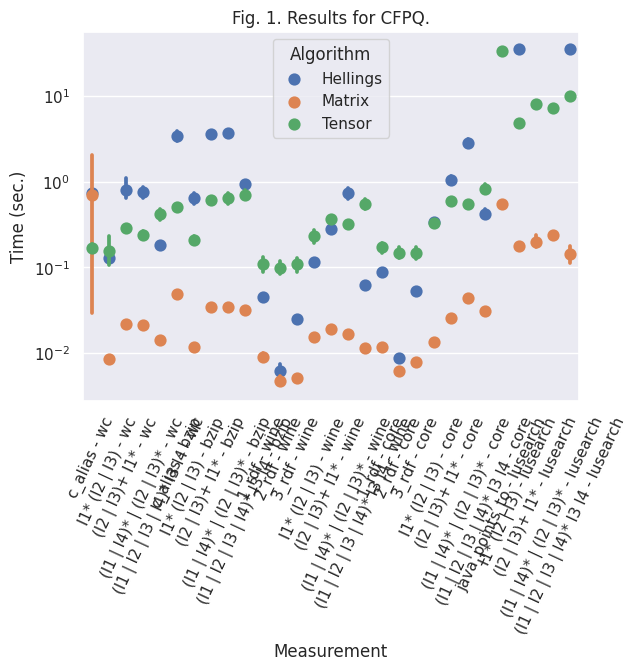

In [13]:
def plot_cfpq_results():
    res = plot[plot["Algorithm type"] == "CFPQ"].copy()
    res["Algorithm"] = res["Algorithm"].map(lambda s: s.removesuffix(" (CFPQ)"))

    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time (sec.)",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Fig. 1. Results for CFPQ.")
    g.set_xticklabels(g.get_xticklabels(), rotation=65)


plot_cfpq_results()

Рассматривая данные результаты, можно заметитить, что быстрее всего отрабатывает матричный алгоритм.

**Сравнение производительности контекстно-свободных алгоритмов и специализировнного алгоритма при использовании регулярных ограничений**

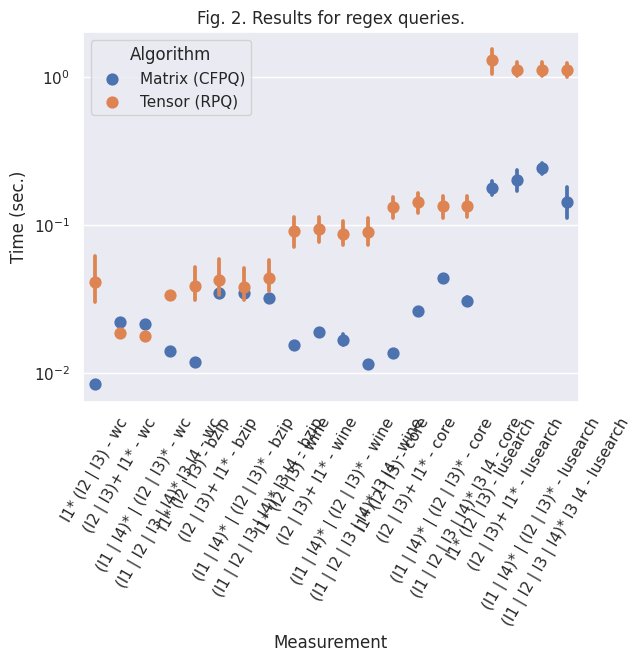

In [14]:
def plot_rpq_results():
    res = plot[(plot["Query type"] == "RPQ") & (plot["Algorithm"].isin(["Matrix", "Tensor (RPQ)"]))].copy()
    res["Algorithm"] = res["Algorithm"].map(lambda s: s + " (CFPQ)" if s == "Matrix" else s)
    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time (sec.)",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Fig. 2. Results for regex queries.")
    g.set_xticklabels(g.get_xticklabels(), rotation=60)


plot_rpq_results()

Поскольку лучше всех показал себя матричный алгоритм, то именно его будем сравнивать с тензорным алгоритмом для регулярных ограничений. Рассматривая результаты для второго вопроса, можно сделать вывод, что матричный алгоритм работает также быстрее и для регулярных ограничениях, чем специализированный алгоритм.

# Заключение

В результате были получены следующие выводы:


> Самым производительным алгоритмов среди рассматриваемых оказался матричный.


> Использование специализированных алгоритмов для регулярных запросов нецелесообразно, поскольку реализация матричного алгоритма для контекстно-свободных запросов оказывается более эффективной и охватывает более широкий диапазон возможных запросов.

